In [32]:
import pandas as pd
import numpy as np
import cv2
import sys
import importlib
SEED = 1234
np.random.seed(SEED) 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, AveragePooling2D, Concatenate, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
import mylibs.ResNet as ResNet
import mylibs.SENet as SENet
importlib.reload(ResNet)
importlib.reload(SENet)
from keras.models import Model

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter

In [2]:
%cd E:\kaggle\iceberg

E:\kaggle\iceberg


In [3]:
def display_img(band_1, band_2, is_iceberg, angle = None):
    if angle is None:
        title_str = 'Iceberg' if is_iceberg == 1 else 'Ship'
    else:
        title_str = 'Iceberg-' + str(angle) if is_iceberg == 1 else 'Ship-' + str(angle)
    fig = plt.figure(0, figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title_str + ' - Band 1')
    ax.imshow(band_1,cmap='jet')
    ax = fig.add_subplot(1,2,2)
    ax.set_title(title_str + ' - Band 2')
    ax.imshow(band_2,cmap='jet')
    plt.show()

# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
    # band: SAR data to be despeckled (already reshaped into image dimensions)
    # window: descpeckling filter window (tuple)
    # default noise variance = 0.25
    # assumes noise mean = 0
    
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2

    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

def apply_lee_filter(band_1_linear, band_2_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var_1 = np.round(np.var(band_1_linear) * noise_var, 10)
    noise_var_2 = np.round(np.var(band_2_linear) * noise_var, 10)
    band_1_linear_filtered = lee_filter(band_1_linear, windows[window_var_index], noise_var_1[noise_var_index])
    band_2_linear_filtered = lee_filter(band_2_linear, windows[window_var_index], noise_var_2[noise_var_index])
    return band_1_linear_filtered, band_2_linear_filtered

def apply_lee_filter_single(band_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var = np.round(np.var(band_linear) * noise_var, 10)
    band_linear_filtered = lee_filter(band_linear, windows[window_var_index], noise_var[noise_var_index])
    return band_linear_filtered

In [4]:
def np_get_scaled_band(band_list):
    imgs = []
    for band in band_list:        
#         imgs.append((band - band.mean()) / (band.max() - band.min()))
        imgs.append(band - band.mean())
    return np.array(imgs)

def get_more_images(imgs):
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
    vh_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        vert_flip_imgs.append(cv2.flip(imgs[i], 1))
        hori_flip_imgs.append(cv2.flip(imgs[i], 0))
        vh_flip_imgs.append(cv2.flip(imgs[i], -1))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    vh = np.array(vh_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h, vh))
    
    return more_images

In [5]:
def display_img(band_1, band_2, is_iceberg, angle = None):
    if angle is None:
        title_str = 'Iceberg' if is_iceberg == 1 else 'Ship'
    else:
        title_str = 'Iceberg-' + str(angle) if is_iceberg == 1 else 'Ship-' + str(angle)
    fig = plt.figure(0, figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title_str + ' - Band 1')
    ax.imshow(band_1,cmap='jet')
    ax = fig.add_subplot(1,2,2)
    ax.set_title(title_str + ' - Band 2')
    ax.imshow(band_2,cmap='jet')
    plt.show()

# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
    # band: SAR data to be despeckled (already reshaped into image dimensions)
    # window: descpeckling filter window (tuple)
    # default noise variance = 0.25
    # assumes noise mean = 0
    
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2

    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

def apply_lee_filter(band_1_linear, band_2_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var_1 = np.round(np.var(band_1_linear) * noise_var, 10)
    noise_var_2 = np.round(np.var(band_2_linear) * noise_var, 10)
    band_1_linear_filtered = lee_filter(band_1_linear, windows[window_var_index], noise_var_1[noise_var_index])
    band_2_linear_filtered = lee_filter(band_2_linear, windows[window_var_index], noise_var_2[noise_var_index])
    return band_1_linear_filtered, band_2_linear_filtered

def apply_lee_filter_single(band_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var = np.round(np.var(band_linear) * noise_var, 10)
    band_linear_filtered = lee_filter(band_linear, windows[window_var_index], noise_var[noise_var_index])
    return band_linear_filtered

In [6]:
train = pd.read_json("E:/kaggle/iceberg/train.json/data/processed/train.json")
target_train=train['is_iceberg']
test = pd.read_json("E:/kaggle/iceberg/test.json/data/processed/test.json")
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')

In [17]:
train["inc_angle"] = train["inc_angle"].replace('na',0)
idx_tr = np.where(train["inc_angle"]>0)
train = train.iloc[idx_tr[0]]
target_train = target_train.iloc[idx_tr[0]]
X_angle=train['inc_angle']
test['inc_angle']=test['inc_angle'].fillna(method='pad')
X_test_angle=test['inc_angle']

In [19]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#apply filter
X_band_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_1])
X_band_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_2])
X_band_1_filtered = linear_to_decibel(X_band_1_filtered)
X_band_2_filtered = linear_to_decibel(X_band_2_filtered)
X_band_1 = X_band_1_filtered
X_band_2 = X_band_2_filtered

X_band_3=np.fabs(np.subtract(X_band_1,X_band_2))
X_band_4=np.maximum(X_band_1,X_band_2)
X_band_5=np.minimum(X_band_1,X_band_2)
X_train = np.concatenate([X_band_3[:, :, :, np.newaxis],X_band_4[:, :, :, np.newaxis],X_band_5[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
#apply filter
X_band_test_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_1])
X_band_test_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_2])
X_band_test_1_filtered = linear_to_decibel(X_band_test_1_filtered)
X_band_test_2_filtered = linear_to_decibel(X_band_test_2_filtered)
X_band_test_1 = X_band_test_1_filtered
X_band_test_2 = X_band_test_2_filtered

X_band_test_3=np.fabs(np.subtract(X_band_test_1,X_band_test_2))
X_band_test_4=np.maximum(X_band_test_1,X_band_test_2)
X_band_test_5=np.minimum(X_band_test_1,X_band_test_2)
X_test = np.concatenate([X_band_test_3[:, :, :, np.newaxis], X_band_test_4[:, :, :, np.newaxis],X_band_test_5[:, :, :, np.newaxis]],axis=-1)

X_train = get_more_images(X_train)
target_train = np.concatenate((target_train, target_train, target_train, target_train))
X_angle = np.concatenate((X_angle, X_angle, X_angle, X_angle))

Xtrain = X_train
Ytrain = target_train
Xtest = X_test
Xangle = X_angle
Xangle_test = X_test_angle
df_train = train
df_test = test

In [20]:
resize_shape = tuple(np.array(Xtrain.shape[1:3]) * 2)
Xtrain = np.array([cv2.resize(img, resize_shape) for img in Xtrain])
Xtest = np.array([cv2.resize(img, resize_shape) for img in Xtest])

In [23]:
print(Xtrain.shape, Ytrain.shape, Xangle.shape, Xtest.shape)

(5884, 150, 150, 3) (5884,) (5884,) (8424, 150, 150, 3)


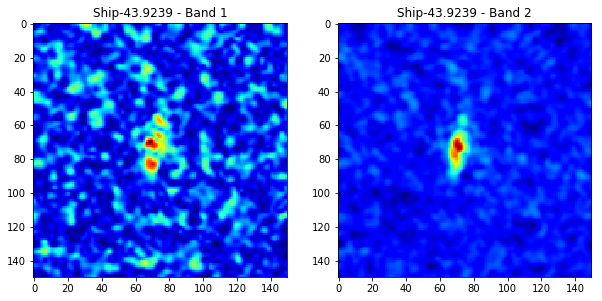

In [28]:
display_img(Xtrain[0,:,:,0], Xtrain[0,:,:,1], Ytrain[0], Xangle[0])

In [45]:
def getModel():
    incept_model = InceptionV3(include_top=False, input_shape=Xtrain.shape[1:], pooling="max")
    x = incept_model.output
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid', name='predictions')(x)
    model = Model(inputs=incept_model.input, outputs=predictions)
    optimizer = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [46]:
model = getModel()
model.summary()
plot_model(model, to_file="inception.png")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_565 (Conv2D)              (None, 74, 74, 32)    864         input_7[0][0]                    
____________________________________________________________________________________________________
batch_normalization_565 (BatchNo (None, 74, 74, 32)    96          conv2d_565[0][0]                 
____________________________________________________________________________________________________
activation_565 (Activation)      (None, 74, 74, 32)    0           batch_normalization_565[0][0]    
___________________________________________________________________________________________

In [48]:
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         channel_shift_range=0,
                         zoom_range = 0.5,
                         rotation_range = 15)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size, seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size, seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

def get_callbacks(filepath):
    es = EarlyStopping('val_loss', patience=20, mode="min")
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave, reduce_lr_loss]

In [50]:
K=3
epochs = 150
batch_size = 64
Kfolds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED).split(Xtrain, Ytrain))
y_test_pred_log = 0
for j, (train_idx, test_idx) in enumerate(Kfolds):
    print('\n===================FOLD=',j)
    Xtrain_cv = Xtrain[train_idx]
    Ytrain_cv = Ytrain[train_idx]
    Xangle_cv = Xangle[train_idx]
    Xtrain_val = Xtrain[test_idx]
    Ytrain_val = Ytrain[test_idx]
    Xangle_val = Xangle[test_idx]
    
    Xtrain_input = Xtrain
    Xtest_input = Xtest
    
    model_file = 'inception_v3_%s.hdf5' % j
    
    mcp_save = ModelCheckpoint(model_file, save_best_only=True, monitor='val_loss', mode='min')
    model = getModel()
    
    model.fit(Xtrain_cv, Ytrain_cv, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, 
              callbacks=get_callbacks(model_file), validation_data=(Xtrain_val, Ytrain_val))
    
    model.load_weights(filepath = model_file)    
    
    score = model.evaluate(Xtrain_input, Ytrain, verbose=1)
    print('Train score:', score[0])
    print('Train accuracy:', score[1])
    y_test_pred_log += model.predict(Xtest_input).reshape(Xtest.shape[0])
    
y_test_pred_log /= K


===================FOLD= 0
Train on 3922 samples, validate on 1962 samples
Epoch 1/150
3922/3922 [==============================] - 146s - loss: 0.5560 - acc: 0.7450 - val_loss: 1.3032 - val_acc: 0.4286
Epoch 2/150
3922/3922 [==============================] - 30s - loss: 0.1956 - acc: 0.9110 - val_loss: 0.5667 - val_acc: 0.6845
Epoch 3/150
3922/3922 [==============================] - 29s - loss: 0.0855 - acc: 0.9694 - val_loss: 0.4603 - val_acc: 0.8114
Epoch 4/150
3922/3922 [==============================] - 29s - loss: 0.0395 - acc: 0.9873 - val_loss: 0.4251 - val_acc: 0.8634
Epoch 5/150
3922/3922 [==============================] - 29s - loss: 0.0211 - acc: 0.9934 - val_loss: 0.3656 - val_acc: 0.8945
Epoch 6/150
3922/3922 [==============================] - 25s - loss: 0.0166 - acc: 0.9939 - val_loss: 0.3701 - val_acc: 0.8909
Epoch 7/150
3922/3922 [==============================] - 25s - loss: 0.0111 - acc: 0.9969 - val_loss: 0.4578 - val_acc: 0.8807
Epoch 8/150
3922/3922 [===========

3904/3922 [============================>.] - ETA: 0s - loss: 2.0465e-04 - acc: 1.0000
Epoch 00060: reducing learning rate to 9.999999974752428e-08.
3922/3922 [==============================] - 25s - loss: 2.0566e-04 - acc: 1.0000 - val_loss: 0.2652 - val_acc: 0.9434
Epoch 62/150
3922/3922 [==============================] - 25s - loss: 4.7217e-04 - acc: 1.0000 - val_loss: 0.2644 - val_acc: 0.9434
Epoch 63/150
3922/3922 [==============================] - 25s - loss: 2.5571e-04 - acc: 1.0000 - val_loss: 0.2652 - val_acc: 0.9439
Epoch 64/150
3922/3922 [==============================] - 25s - loss: 8.2929e-05 - acc: 1.0000 - val_loss: 0.2656 - val_acc: 0.9439
Epoch 65/150
3922/3922 [==============================] - 25s - loss: 0.0022 - acc: 0.9995 - val_loss: 0.2651 - val_acc: 0.9450
Epoch 66/150
3922/3922 [==============================] - 25s - loss: 1.7669e-04 - acc: 1.0000 - val_loss: 0.2648 - val_acc: 0.9455
Epoch 67/150
5884/5884 [==============================] - 13s    
Train score

5884/5884 [==============================] - 13s    
Train score: 0.0661322792189
Train accuracy: 0.983004758668

===================FOLD= 2
Train on 3923 samples, validate on 1961 samples
Epoch 1/150
3923/3923 [==============================] - 220s - loss: 0.5952 - acc: 0.7270 - val_loss: 1.0326 - val_acc: 0.5370
Epoch 2/150
3923/3923 [==============================] - 30s - loss: 0.2151 - acc: 0.9039 - val_loss: 0.6820 - val_acc: 0.6792
Epoch 3/150
3923/3923 [==============================] - 30s - loss: 0.1019 - acc: 0.9605 - val_loss: 0.3886 - val_acc: 0.8292
Epoch 4/150
3923/3923 [==============================] - 30s - loss: 0.0438 - acc: 0.9873 - val_loss: 0.3815 - val_acc: 0.8598
Epoch 5/150
3923/3923 [==============================] - 31s - loss: 0.0178 - acc: 0.9946 - val_loss: 0.3813 - val_acc: 0.8960
Epoch 6/150
3923/3923 [==============================] - 30s - loss: 0.0159 - acc: 0.9954 - val_loss: 0.3550 - val_acc: 0.8893
Epoch 7/150
3923/3923 [=========================

In [52]:
submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': y_test_pred_log})
print(submission.count(), Xtest.shape[0])

submission.to_csv('submission-inception-v3.csv', index=False)

id            8424
is_iceberg    8424
dtype: int64 8424
